In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("bioAI.mplstyle")
import torch
import tqdm

import sys
sys.path.append('../')
from models import *
from methods import *
from plotting_functions import set_size

In [2]:
def train_model(model):
    # Train model
    nsamples_space = 2**6
    loss_history = []
    for epoch in tqdm.trange(2000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=torch.float32)
        loss = model.train_step(rs)
        loss_history.append(loss)
    loss_history = np.array(loss_history)
    return loss_history

In [3]:
N_nrns = [3,4,6,7,10,25,50,100,250,500,1000]
n_perms = 100
decoding_performance = torch.zeros(4, len(N_nrns), n_perms)
isometry_performance = torch.zeros(4, len(N_nrns), n_perms)
homology_performance = torch.zeros(4, len(N_nrns), n_perms)

for i,n in enumerate(N_nrns):
    for j in range(n_perms):
        models = [HexagonalGCs(ncells=n,lr=1e-2),        
        LinDecoder(ncells=n,lr=1e-2),
        JacobianCI(ncells=n,lr=1e-2),
        Homology(ncells=n,lr=1e-2)]
    
        #train_model(model_rand)
        loss_LIN = train_model(models[1])
        loss_CI = train_model(models[2])
        loss_HOM = train_model(models[3])
    
        #evaluate models on each other
        for k, mod in enumerate(models):
            rs = mod.unit_cell.sample(2**6)
            rs = torch.tensor(rs,dtype=torch.float32)
            
            temp_mod = LinDecoder(ncells=n,least_squares=True)
            temp_mod.set_phases(mod.phases)
            decoding_performance[k,i,j] = temp_mod.loss_fn(rs)

            temp_mod = JacobianCI(ncells=n)
            temp_mod.set_phases(mod.phases)
            isometry_performance[k,i,j] = temp_mod.loss_fn(rs)
            
            temp_mod = Homology(ncells=n)
            temp_mod.set_phases(mod.phases)
            homology_performance[k,i,j] = temp_mod.loss_fn(rs)

100%|████████████████████████████████████████| 2000/2000 [00:17<00:00, 112.78it/s]


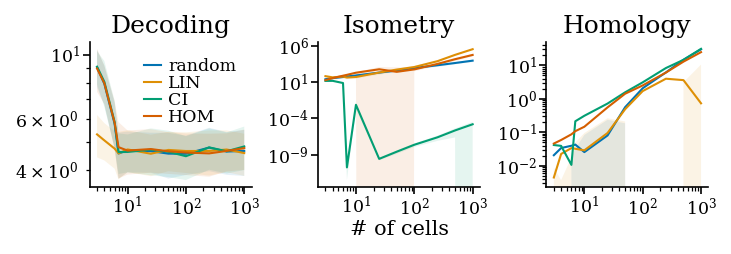

In [7]:
mean_decoding = torch.mean(decoding_performance,axis=2).detach().numpy()
std_decoding = torch.std(decoding_performance,axis=2).detach().numpy()

mean_isometry = torch.mean(isometry_performance,axis=2).detach().numpy()
std_isometry = torch.std(isometry_performance,axis=2).detach().numpy()

mean_homology = torch.mean(homology_performance,axis=2).detach().numpy()
std_homology = torch.std(homology_performance,axis=2).detach().numpy()

figsize=set_size(fraction=(1,1/3),mode='square')
fig, axs = plt.subplots(1,3,figsize=figsize)

axs[0].plot(N_nrns,mean_decoding.T)
[axs[0].fill_between(N_nrns, mean_decoding[i]+std_decoding[i],
                     mean_decoding[i]-std_decoding[i],
                    alpha=0.1) for i in range(len(decoding_performance))]
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(['random','LIN','CI','HOM'])
axs[0].set_title('Decoding')

axs[1].plot(N_nrns,mean_isometry.T)
[axs[1].fill_between(N_nrns, mean_isometry[i]+std_isometry[i],
                     mean_isometry[i]-std_isometry[i],
                    alpha=0.1) for i in range(len(isometry_performance))]
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Isometry')
axs[1].set_xlabel('# of cells')

axs[2].plot(N_nrns,-mean_homology.T)
[axs[2].fill_between(N_nrns, mean_homology[i]+std_homology[i],
                     mean_homology[i]-std_homology[i],
                    alpha=0.1) for i in range(len(homology_performance))]
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_title('Homology')

fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

fig.savefig("./F5-model-comparison.pdf")